# Using the OpenAQ API

The `openaq` api is an easy-to-use wrapper built around the [OpenAQ Api](https://docs.openaq.org/). Complete API documentation can be found on their website. 

There are no keys or rate limits (as of March 2017), so working with the API is straight forward. If building a website or app, you may want to just use the python wrapper and interact with the data in json format. However, the rest of this tutorial will assume you are interested in analyzing the data. To get more out of it, I recommend installing `seaborn` for manipulating the asthetics of plots, and working with data as DataFrames using `pandas`. For more information on these, check out the installation section of this documentation.

From this point forward, I assume you have at least a basic knowledge of python and matplotlib. This documentation was built using the following versions of all packages:

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import openaq
import warnings

warnings.simplefilter('ignore')

%matplotlib inline

# Set major seaborn asthetics
sns.set("notebook", style='ticks', font_scale=1.0)

print ("pandas v{}".format(pd.__version__))
print ("matplotlib v{}".format(mpl.__version__))
print ("seaborn v{}".format(sns.__version__))
print ("openaq v{}".format(openaq.__version__))

pandas v0.19.0
matplotlib v1.5.3
seaborn v0.7.1
openaq v1.0.2


## OpenAQ API

The OpenAQ APi has only eight endpoints that we are interested in:

  * cities: provides a simple listing of cities within the platforms
  * countries: provides a simple listing of countries within the platform
  * fetches: providing data about individual fetch operations that are used to populate data in the platform
  * latest: provides the latest value of each available parameter for every location in the system
  * locations: provides a list of measurement locations and their meta data
  * measurements: provides data about individual measurements
  * parameters: provides a simple listing of parameters within the platform
  * sources: provides a list of data sources
  
For detailed documentation about each one in the context of this API wrapper, please check out the API documentation.

### Your First Request

Real quick, let's go ahead and initiate an instance of the `openaq.OpenAQ` class so we can begin looking at data:

In [2]:
api = openaq.OpenAQ()

### Cities

The cities API endpoint lists the cities available within the platform. Results can be subselected by country and paginated to retrieve all results in the database. Let's start by performing a basic query with an increased limit (so we can get all of them) and return it as a DataFrame:

In [3]:
resp = api.cities(df=True, limit=10000)

# display the first 10 rows
resp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1418 entries, 0 to 1417
Data columns (total 4 columns):
city         1418 non-null object
count        1418 non-null int64
country      1418 non-null object
locations    1418 non-null int64
dtypes: int64(2), object(2)
memory usage: 44.4+ KB


So we retrieved 1400+ entries from the database. We can then take a look at them:

In [4]:
resp.head(10)

,city,count,country,locations
0,21 de mayo,2,CL,1
1,ABBEVILLE,4619,US,1
2,Aberdeen,49021,GB,3
3,Aberdeen,13499,US,2
4,ADA,16206,US,1
5,ADAIR,28818,US,1
6,ADAMS,22729,US,2
7,Adana,29046,TR,4
8,Addis Ababa,7923,ET,2
9,Adrian,12602,US,1


Let's try to find out which ones are in India:

In [5]:
resp.query("country == 'IN'")

,city,count,country,locations
10,Agra,39829,IN,1
11,Ahmedabad,35118,IN,1
39,Amritsar,3773,IN,1
95,Aurangabad,49526,IN,1
119,Barddhaman,2470,IN,3
141,Bengaluru,175342,IN,5
283,Chandrapur,99748,IN,2
293,Chennai,113654,IN,4
304,Chittoor,2013,IN,1
379,Delhi,548428,IN,16


Great! For the rest of the tutorial, we are going to focus on Delhi, India. Why? Well..because there are over 500,000 data points and my personal research is primarily in India. We will also take a look at some $SO_2$ data from Hawai'i later on (another great research locale).

## Countries

Similar to the `cities` endpoint, the `countries` endpoint lists the countries available. The only parameters we have to play with are the limit and page number. If we want to grab them all, we can just up the limit to the maximum (10000).

In [6]:
res = api.countries(limit=10000, df=True)

res

,cities,code,count,locations,name
0,1,AR,2448,1,Argentina
1,370,AT,360033,370,Austria
2,56,AU,1312494,56,Australia
3,11,BA,325020,11,Bosnia and Herzegovina
4,2,BD,10170,2,Bangladesh
5,98,BE,316151,98,Belgium
6,1,BH,2425,1,Bahrain
7,147,BR,1972902,147,Brazil
8,157,CA,1222881,157,Canada
9,162,CL,2888697,162,Chile


## Fetches

If you are interested in getting information pertaining to the individual data fetch operations, go ahead and use this endpoint. Most people won't need to use this. This API method does not allow the `df` parameter; if you would like it to be added, drop me a message.

Otherwise, here is how you can access the json-formatted data:

In [7]:
status, resp = api.fetches(limit=1)

# Print out the meta info
print (resp['meta'])

{'license': 'CC BY 4.0', 'limit': 1, 'website': 'https://docs.openaq.org/', 'page': 1, 'pages': 55669, 'name': 'openaq-api', 'found': 55669}


## Parameters

The `parameters` endpoint will provide a listing off all the parameters available:

In [8]:
res = api.parameters(df=True)

res

,description,id,name,preferredUnit
0,Particulate matter less than 2.5 micrometers i...,pm25,PM2.5,µg/m³
1,Particulate matter less than 10 micrometers in...,pm10,PM10,µg/m³
2,Nitrogen Dioxide,no2,NO2,ppm
3,Sulfur Dioxide,so2,SO2,ppm
4,Ozone,o3,O3,ppm
5,Carbon Monoxide,co,CO,ppm
6,Black Carbon,bc,BC,µg/m³


## Sources

The `sources` endpoint will provide a list of the sources where the raw data came from.

In [9]:
res = api.sources(df=True)

res.head()

,active,adapter,city,contacts,country,description,name,resolution,sourceURL,url
0,True,eea,,"[olaf.veerman@gmail.com, info@openaq.org]",AD,Andoran data from UTD service,EEA Andora,NaN,http://www.eea.europa.eu/themes/air/air-quality,None
1,True,eea,,"[olaf.veerman@gmail.com, info@openaq.org]",AT,Austrian data from UTD service,EEA Austria,NaN,http://www.eea.europa.eu/themes/air/air-quality,None
2,True,nsw,,"[info@openaq.org, olaf@developmentseed.org]",AU,Measurements from the Office of Environment & ...,Australia - New South Wales,1 hr,http://www.environment.nsw.gov.au/AQMS/hourlyd...,http://airquality.environment.nsw.gov.au/aquis...
3,True,queensland,,[info@openaq.org],AU,Measurements from Department of Environment an...,Australia - Queensland,1 hr,https://data.qld.gov.au/dataset/air-quality-mo...,http://www.ehp.qld.gov.au/cgi-bin/air/xml.php?...
4,True,fhmzbih,NaN,[info@openaq.org],BA,,Bosnia,NaN,http://www.fhmzbih.gov.ba/latinica/AKTUELNI/A-...,http://www.fhmzbih.gov.ba/latinica/AKTUELNI/zr...


## Locations

The `locations` endpoint will return the list of measurement locations and their meta data. We can do quite a bit of querying with this one:

Let's see what the data looks like:

In [10]:
res = api.locations(df=True)

res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
city                     100 non-null object
coordinates.latitude     100 non-null float64
coordinates.longitude    100 non-null float64
count                    100 non-null int64
country                  100 non-null object
firstUpdated             100 non-null datetime64[ns]
lastUpdated              100 non-null datetime64[ns]
location                 100 non-null object
parameters               100 non-null object
sourceName               100 non-null object
sourceNames              100 non-null object
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 8.7+ KB


In [11]:
res.head(3)

,city,coordinates.latitude,coordinates.longitude,count,country,firstUpdated,lastUpdated,location,parameters,sourceName,sourceNames
0,Ulaanbaatar,47.932906,106.921383,216718,MN,2015-09-01 00:00:00,2017-03-13 03:45:00,100 ail,"[co, no2, o3, pm10, so2]",Agaar.mn,[Agaar.mn]
1,Omaha-Council Bluffs,41.322472,-95.937992,12639,US,2016-03-06 19:00:00,2017-03-13 02:00:00,16th and Whitmore,"[o3, so2]",AirNow,[AirNow]
2,Farmington,36.809700,-107.651700,6731,US,2016-03-06 19:00:00,2017-01-13 15:00:00,1NL Navajo Lake,[o3],AirNow,[AirNow]


What if we just want to grab the locations in Delhi?

In [12]:
res = api.locations(city='Delhi', df=True)

res

,city,coordinates.latitude,coordinates.longitude,count,country,firstUpdated,lastUpdated,location,parameters,sourceName,sourceNames
0,Delhi,28.65080,77.31520,62031,IN,2015-06-29 14:30:00,2017-03-13 03:25:00,Anand Vihar,"[co, no2, o3, pm10, pm25, so2]",CPCB,"[Anand Vihar, CPCB]"
1,Delhi,28.67870,77.22620,4,IN,2015-07-10 08:15:00,2015-07-10 08:15:00,Civil Lines,"[co, no2, pm10, pm25]",CPCB,[CPCB]
2,Delhi,28.74400,77.12000,1,IN,2015-04-09 06:00:00,2015-04-09 06:00:00,Delhi College Of Engineering,[o3],CPCB,[CPCB]
3,Delhi,28.74400,77.12000,6702,IN,2016-11-02 18:30:00,2017-03-13 03:30:00,Delhi Technological University,"[no2, pm25]",CPCB,[CPCB]
4,Delhi,NaN,NaN,436,IN,2016-04-02 01:30:00,2016-04-05 09:00:00,East Arjun Nagar,"[no2, o3]",CPCB,[CPCB]
5,Delhi,NaN,NaN,11881,IN,2016-04-04 18:30:00,2017-03-12 05:15:00,East Arjun Nagar-Delhi CPCB,"[no2, o3]",CPCB,[CPCB]
6,Delhi,28.56000,77.09400,5,IN,2015-07-10 06:30:00,2015-07-10 06:30:00,IGI Airport,"[co, no2, o3, pm10, pm25]",CPCB,[CPCB]
7,Delhi,28.68210,77.30500,19832,IN,2016-04-10 18:30:00,2017-03-13 03:30:00,IHBAS,"[co, no2, pm25]",CPCB,[CPCB]
8,Delhi,28.62350,77.24940,34562,IN,2016-01-23 03:15:00,2017-03-13 03:30:00,Income Tax Office,"[co, no2, o3, pm10, pm25]",CPCB,[CPCB]
9,Delhi,28.63410,77.20050,69591,IN,2015-06-29 14:30:00,2017-03-13 03:25:00,Mandir Marg,"[co, no2, o3, pm10, pm25, so2]",CPCB,"[CPCB, Mandir Marg]"


What about just figuring out which locations in Delhi have $PM_{2.5}$ data?

In [13]:
res = api.locations(city='Delhi', parameter='pm25', df=True)

res

,city,coordinates.latitude,coordinates.longitude,count,country,firstUpdated,lastUpdated,location,parameters,sourceName,sourceNames
0,Delhi,28.65080,77.31520,14975,IN,2015-06-29 14:30:00,2017-03-13 03:25:00,Anand Vihar,[pm25],CPCB,"[Anand Vihar, CPCB]"
1,Delhi,28.67870,77.22620,1,IN,2015-07-10 08:15:00,2015-07-10 08:15:00,Civil Lines,[pm25],CPCB,[CPCB]
2,Delhi,28.74400,77.12000,3068,IN,2016-11-02 18:30:00,2017-03-13 03:30:00,Delhi Technological University,[pm25],CPCB,[CPCB]
3,Delhi,28.56000,77.09400,1,IN,2015-07-10 06:30:00,2015-07-10 06:30:00,IGI Airport,[pm25],CPCB,[CPCB]
4,Delhi,28.68210,77.30500,789,IN,2017-02-18 20:45:00,2017-03-13 03:30:00,IHBAS,[pm25],CPCB,[CPCB]
5,Delhi,28.62350,77.24940,11294,IN,2016-11-02 18:30:00,2017-03-13 03:30:00,Income Tax Office,[pm25],CPCB,[CPCB]
6,Delhi,28.63410,77.20050,16413,IN,2015-06-29 14:30:00,2017-03-13 03:25:00,Mandir Marg,[pm25],CPCB,"[CPCB, Mandir Marg]"
7,Delhi,28.59100,77.05000,1559,IN,2017-02-18 18:30:00,2017-03-10 07:15:00,NSIT Dwarka,[pm25],CPCB,[CPCB]
8,Delhi,28.66830,77.11670,19706,IN,2015-06-29 00:30:00,2017-03-12 07:05:00,Punjabi Bagh,[pm25],CPCB,"[CPCB, Punjabi Bagh]"
9,Delhi,28.56480,77.17440,17370,IN,2015-06-29 14:30:00,2017-03-13 02:55:00,R K Puram,[pm25],CPCB,"[CPCB, RK Puram]"


## Latest

Grab the latest data from a location or locations.

What was the most recent $PM_{2.5}$ data in Delhi?

In [14]:
res = api.latest(city='Delhi', parameter='pm25', df=True)

res

,city,country,location,parameter,sourceName,unit,value
lastUpdated,,,,,,,
2017-03-13 03:25:00,Delhi,IN,Anand Vihar,pm25,CPCB,µg/m³,243.00
2015-07-10 08:15:00,Delhi,IN,Civil Lines,pm25,CPCB,µg/m³,48.99
2017-03-13 03:30:00,Delhi,IN,Delhi Technological University,pm25,CPCB,µg/m³,299.00
2015-07-10 06:30:00,Delhi,IN,IGI Airport,pm25,CPCB,µg/m³,56.82
2017-03-13 03:30:00,Delhi,IN,IHBAS,pm25,CPCB,µg/m³,79.00
2017-03-13 03:30:00,Delhi,IN,Income Tax Office,pm25,CPCB,µg/m³,131.00
2017-03-13 03:25:00,Delhi,IN,Mandir Marg,pm25,CPCB,µg/m³,201.00
2017-03-10 07:15:00,Delhi,IN,NSIT Dwarka,pm25,CPCB,µg/m³,798.40
2017-03-12 07:05:00,Delhi,IN,Punjabi Bagh,pm25,CPCB,µg/m³,40.00


What about the most recent $SO_2$ data in Hawii?

In [15]:
res = api.latest(city='Hilo', parameter='so2', df=True)

res

,city,country,location,parameter,sourceName,unit,value
lastUpdated,,,,,,,
2017-03-12 20:00:00,Hilo,US,Hawaii Volcanoes NP,so2,AirNow,ppm,0.000
2017-03-13 02:00:00,Hilo,US,Hilo,so2,AirNow,ppm,0.001
2017-03-13 02:00:00,Hilo,US,Kona,so2,AirNow,ppm,0.006
2017-03-13 02:00:00,Hilo,US,Ocean View,so2,AirNow,ppm,0.015
2017-03-13 02:00:00,Hilo,US,Pahala,so2,AirNow,ppm,0.002
2017-01-26 17:00:00,Hilo,US,Puna E Station,so2,AirNow,ppm,0.002


## Measurements

Finally, the endpoint we've all been waiting for! Measurements allows you to grab all of the dataz! You can query on a whole bunhc of parameters listed in the API documentation. Let's dive in:

Let's grab the past 10000 data points for $PM_{2.5}$ in Delhi:

In [22]:
res = api.measurements(city='Delhi', parameter='pm25', limit=10000, df=True)

# Print out the statistics on a per-location basiss
res.groupby(['location'])['value'].describe()

location                             
Anand Vihar                     count     499.000000
                                mean       93.052104
                                std        53.770758
                                min         1.000000
                                25%        56.000000
                                50%        79.000000
                                75%       114.000000
                                max       329.000000
Delhi Technological University  count     963.000000
                                mean      104.106957
                                std        76.431671
                                min        15.000000
                                25%        47.500000
                                50%        80.000000
                                75%       143.000000
                                max       568.000000
IHBAS                           count     740.000000
                                mean       63.042973
        

Clearly, we should be doing some serious data cleaning ;) Why don't we go ahead and plot all of these locations on a figure.

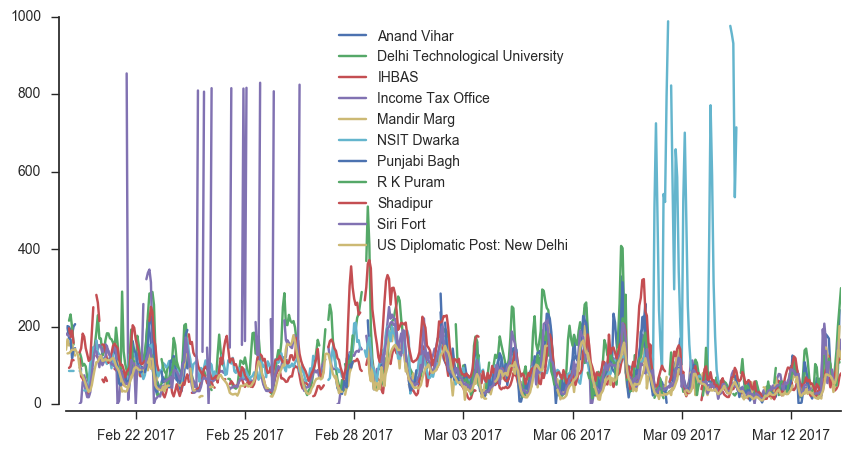

In [39]:
fig, ax = plt.subplots(1, figsize=(10, 5))

for group, df in res.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('1h').mean()
    
    ax.plot(_df.value, label=group)
    
ax.legend(loc='best')

sns.despine(offset=5)

plt.show()

Don't worry too much about how ugly and uninteresting the plot above is...we'll take care of that in the next tutorial! Let's go ahead and look at the distribution of $PM_{2.5}$ values seen in Delhi by various sensors. This is the same data as above, but viewed in a different way.

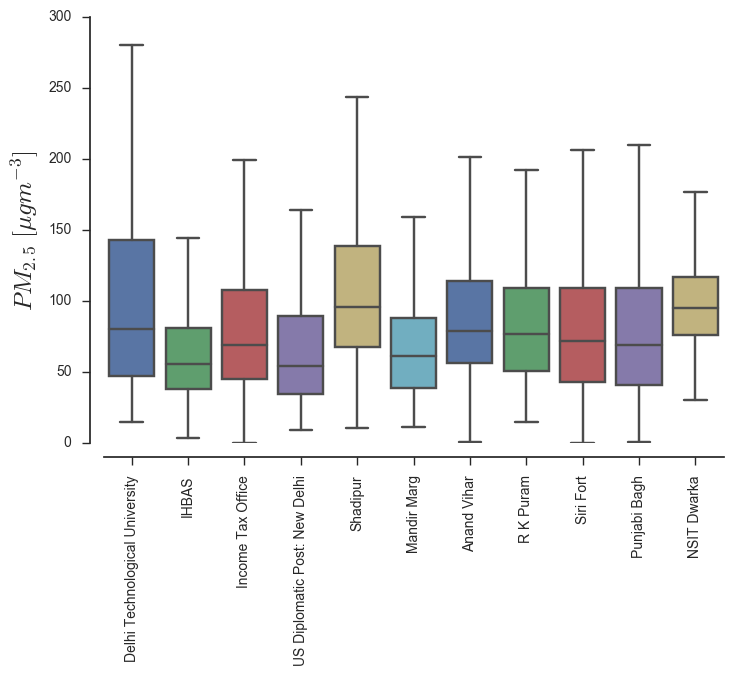

In [60]:
ax = sns.boxplot(x='location', y='value', data=res.query("value >= 0.0"), fliersize=0, palette='deep')

ax.set_ylim([0, 300])
ax.set_ylabel("$PM_{2.5}\;[\mu gm^{-3}]$", fontsize=18)
ax.set_xlabel("")

sns.despine(offset=10)

plt.xticks(rotation=90)
plt.show()

If we remember from above, there was at least one location where many parameters were measured. Let's go ahead and look at that location and see if there is any correlation among parameters!

In [70]:
res = api.measurements(city='Delhi', location='Anand Vihar', limit=10000, df=True)

# Which params do we have?
res.parameter.unique()

array(['pm10', 'pm25', 'o3', 'no2'], dtype=object)

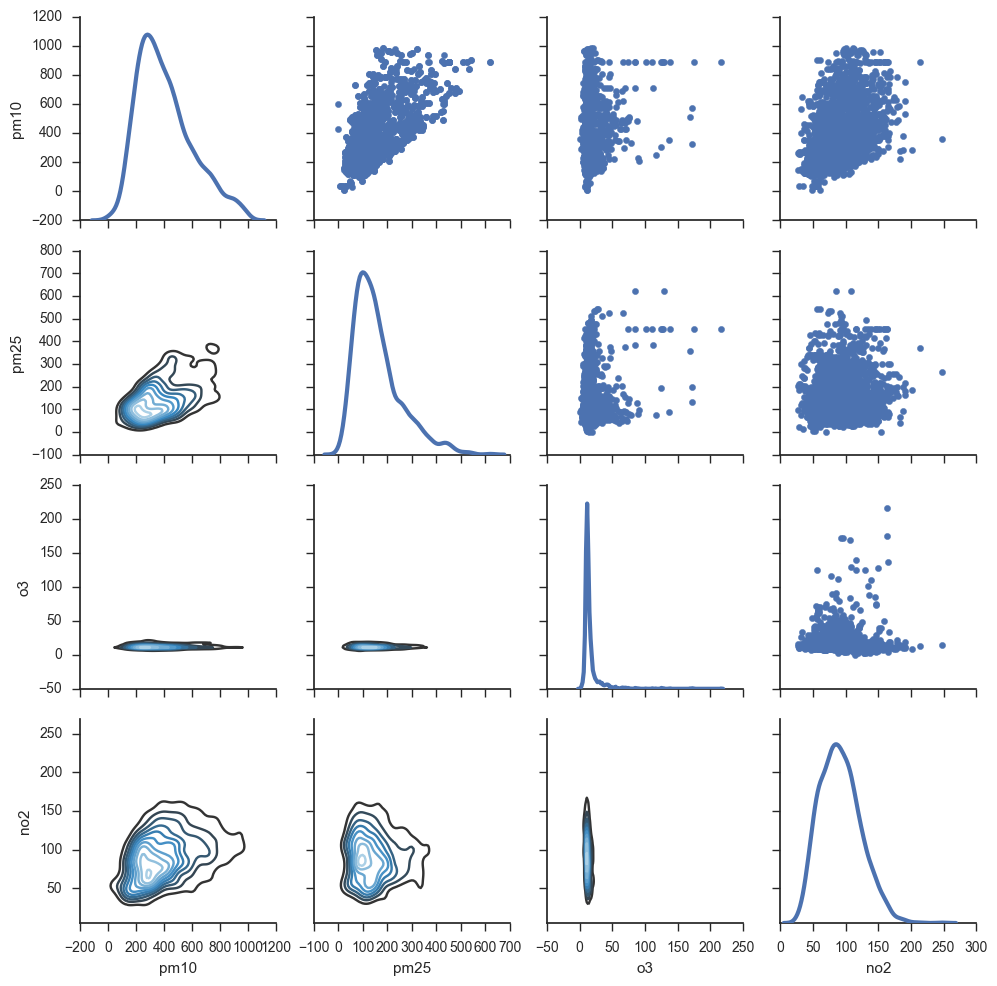

In [89]:
df = pd.DataFrame()

for u in res.parameter.unique():
    _df = res[res['parameter'] == u][['value']]
    _df.columns = [u]
    
    # Merge the dataframes together
    df = pd.merge(df, _df, left_index=True, right_index=True, how='outer')

# Get rid of rows where not all exist
df.dropna(how='any', inplace=True)

g = sns.PairGrid(df, diag_sharey=False)

g.map_lower(sns.kdeplot, cmap='Blues_d')
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

plt.show()

For kicks, let's go ahead and look at a timeseries of $SO_2$ data in Hawai'i. Quiz: What do you expect? Did you know that Hawai'i has a huge $SO_2$ problem?

In [61]:
res = api.measurements(city='Hilo', parameter='so2', limit=10000, df=True)

# Print out the statistics on a per-location basiss
res.groupby(['location'])['value'].describe()

location                  
Hawaii Volcanoes NP  count    1410.000000
                     mean        0.021430
                     std         0.060089
                     min         0.000000
                     25%         0.000000
                     50%         0.000000
                     75%         0.009000
                     max         0.552000
Hilo                 count    1883.000000
                     mean        0.005977
                     std         0.023855
                     min         0.000000
                     25%         0.000000
                     50%         0.001000
                     75%         0.003000
                     max         0.640000
Kona                 count    2001.000000
                     mean        0.003688
                     std         0.006681
                     min         0.000000
                     25%         0.001000
                     50%         0.002000
                     75%         0.005000
       

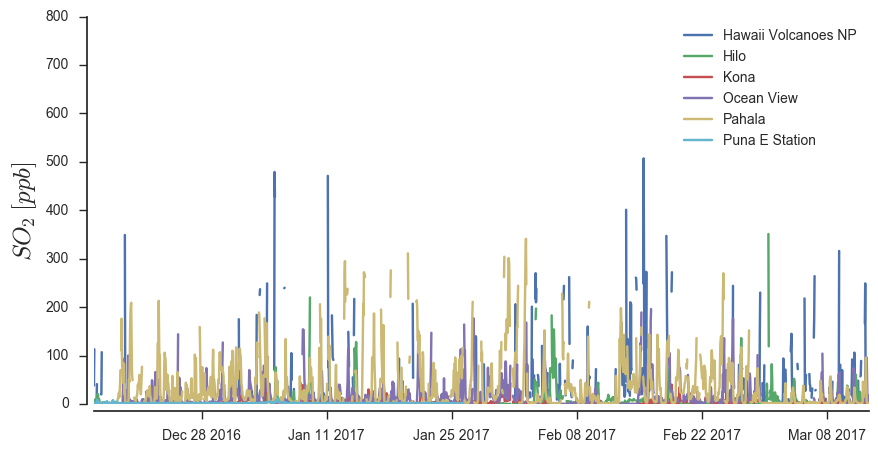

In [65]:
fig, ax = plt.subplots(1, figsize=(10, 5))

for group, df in res.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('1h').mean()
    
    # Multiply the value by 1000 to get from ppm to ppb
    ax.plot(_df.value * 1000., label=group)
    
ax.legend(loc='best')
ax.set_ylabel("$SO_2 \; [ppb]$", fontsize=18)

sns.despine(offset=5)

plt.show()

**NOTE:** These values are for 1h means. The local readings can actually get much, much higher (>5 ppm!) when looking at 1min data.